In [1]:
import os 
os.chdir("/u/phg/adas")
%matplotlib inline
import matplotlib
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt

import atomdat.adas.adf11 as adf11
import atomdat.adas.adf13 as adf13
import atomdat.adas.adf15 as adf15

# testing

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


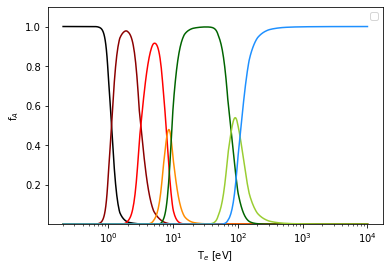

In [8]:
import adas.ibal_phg as ibal; reload(ibal)
from adas.ibal_phg import calc_fz_extra as phg_calc_fz
tecoronal, fzcoronal, spl = ibal.coronal(elem="c",
                                         pn='/u/phg/adas/adf11/',fplt=False)
_ = ibal.plot_fz(tecoronal, fzcoronal)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


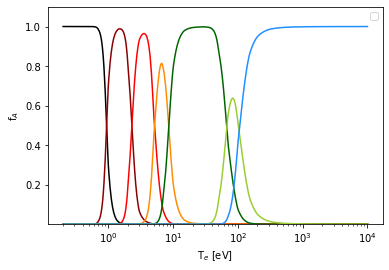

In [9]:
import atomdat.adas.ibal_phg as ibal; reload(ibal)
ne = np.ones_like(tecoronal)*8E20
_,fzc,lzc,lzlc = ibal.calc_fz(elem='c',
                              pn='/u/phg/adas/adf11/',
                              te=tecoronal,
                              ne=ne)
_ = ibal.plot_fz(tecoronal, fzc)

In [10]:
elem = "c"
te = tecoronal
ne = 1e20
n0 = 0
e0 = 1
l0 = 1

In [11]:
plt.close("all")
_,fz,_,_ = phg_calc_fz("c", te=te, ne=1e20, fplt=False,
                      n0=ne, e0=0.2)
_ = ibal.plot_fz(te, fz)

ValueError: too many values to unpack (expected 4)

In [12]:
import atomdat.adas.ibal_phg as ibal
import scipy.interpolate as spi
import scipy.linalg as scl

def phg_calc_fz(elem, nt=int(1.E2),  # nt = num of points
        ne=None, # electron density
        te=None, # and electron temperature vlaue arrays
        s=None, taus=0.,taua=0,  # different source terms
        n0=0.,l0=0.1,e0=0.2, # neutral density paramteters 
        fplt=False,
        debug=False,
        fsilent=False):
    '''
    #Transport loss terms 
    ta - to hotter regions
    ts - to colder regions
    s  - source term
    '''

    pn = '/u/phg/adas/adf11/'
    year = ["96"]*5

    fns = 'scd'+year[0]+'/scd'+year[0]+'_'+elem+'.dat'; scd = adf11.ADF11(fns,pn=pn)
    fna = 'acd'+year[1]+'/acd'+year[1]+'_'+elem+'.dat'; acd = adf11.ADF11(fna,pn=pn)
    fnc = 'ccd'+year[2]+'/ccd'+year[2]+'_'+elem+'.dat'; ccd = adf11.ADF11(fnc,pn=pn)
    fnt = 'plt'+year[3]+'/plt'+year[3]+'_'+elem+'.dat'; prt = adf11.ADF11(fnt,pn=pn)
    fnb = 'prb'+year[4]+'/prb'+year[4]+'_'+elem+'.dat'; prb = adf11.ADF11(fnb,pn=pn)

  
    #Provide temperatures & densities
    nz = acd.dat.nz
    if te is None:
        ter = [acd.dat.te.min(),acd.dat.te.max()]
        te  = np.logspace(ter[0],ter[1],nt)
    nt = te.shape[0]

    if ne is None:
        ne = np.ones(te.shape)*1E17
        print('Assume coronal equilibrium (1E17 m-3)')
    if type(ne) is float:
        ne = np.ones(te.shape)*ne

    #Provide neutral densities for CX
    if type(n0) != int and type(n0) != float:
        ...
    elif n0 > 0.:
        n0l = np.exp(-te**e0/l0)
        n0 = n0*n0l/n0l.max()
    else:
        n0 = n0l = np.zeros(nt)


    #Provide source terms
    if s is None:
        s = np.array([0. for i in range(nt)])

    fz = np.zeros((nt,nz+1))
    lz  = np.zeros((nt,nz+1))
    lzl = np.zeros((nt,nz+1))

    m = ibal.make_transition_matrix(acd,scd,ccd,ne,te,n0,taus,taua,fsilent=fsilent)

    for i in range(nt):
        tmp = m[:,:,i]
        #Normalize matrix
        #norm = tmp.max()
        #tmp = tmp/norm
        #s = s/norm

        #Solve kernel for fractional abundance
        z = np.abs(scl.null_space(tmp))
        if z.shape[1] > 1: z = z[:,0]
        z = np.squeeze(z)
        #Normalize fractional abundance (Why did this not work with matrix?)
        fz[i,:] = z/z.sum()
        #x = np.linalg.solve(m,s)


    #Determine Lz function
    for j in range(nz):
        interpol_prt = prt.interpolate(ne,te,j,silent=fsilent)*fz[:,j]
        lzl[:,j] = interpol_prt
        lz[:,j]  = interpol_prt
        lz[:,j] += prb.interpolate(ne,te,j,silent=fsilent)*fz[:,j]

    #Total radiative power function
    lz[:,-1] = np.sum(lz,1)
    lzl[:,-1] = np.sum(lzl,1)
    
    if fplt:
        if n0[0] > 0.:
            fig, ax = plt.subplots()
            ax.plot(te,n0)
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.set_ylabel('n$_0$ [m-3]')
            ax.set_xlabel('T$_e$ [eV]')
            ax.set_ylim((1.E10,1.E21))
            plt.show(block=False)
            
    return te, fz, lz, lzl

In [13]:
lcol = ['k','b','g','y','orange','r','violet','brown','gray']
import utils.colors as colors; reload(colors); clrs = colors.clrs()
def phg_plot_fz(te, fz, fig=None, ax=None, labels=None, **kwargs):
    nz = fz.shape[1] # ionisations
    if fig is None:
        fig = plt.figure()
    if ax is None: 
        ax = fig.gca()

    col = clrs.resetnull()
    for i in range(nz):
        if i == 4 or i == 6:
            clrs.next()
        if i == 5:
            col = clrs.resetnull()
            [clrs.next() for i in range(4)]
            
        label = labels[i] if labels is not None else None
        ax.plot(te,fz[:,i],c=clrs.next(), label=label, **kwargs)
        #ax.plot(te,fz[:,i],c=lcol[i], label=label, **kwargs)
    
    ax.set_xlabel('T$_e$ [eV]')
    ax.set_ylabel('f$_A$')
    ax.set_xscale('log')
    
    if labels is not None:
        ax.legend()
    return fig

# plotting different variants

In [19]:
%matplotlib inline
import atomdat.adas.ibal_phg as ibal; reload(ibal)
plt.close("all")

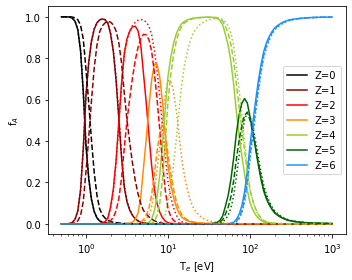

In [20]:
fig, ax = plt.subplots(figsize=(5,4))

N = 100
te = np.logspace(np.log10(5e-1),np.log10(1e3),N)
labels = [f"Z={i}" for i in range(10)]

ne = np.ones(N)*1E20
n0 = np.logspace(21,13,N)
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, n0=n0)
_ = phg_plot_fz(te, fz, fig=fig, ax=ax, ls=":")

ne = np.ones(N)*1E20
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne)
_ = phg_plot_fz(te, fz, fig=fig, ax=ax, labels=labels)

ne = np.ones(N)*6E13
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne)
_ = phg_plot_fz(te, fz, fig=fig, ax=ax, ls="--")

fig.tight_layout()

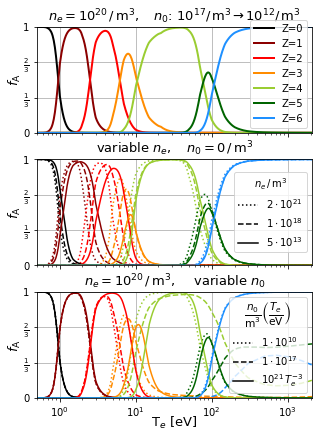

In [25]:
fig, axs = plt.subplots(nrows=3, sharex=True, figsize=(4.3,6))

N = 500
lw = [2,1.5,1.5]
te = np.logspace(np.log10(5e-1),np.log10(2.1e3),N)
labels = [f"Z={i}" for i in range(10)]
extralabels = [#r"$n_e=10^{20}\,/\,\mathrm{m}^3 ,\quad n_0="
               #"\genfrac{\{}{}{0}{0}{10^{17}}{10^{21}\,T_e^{-3}}$",
               #r"$n_e=10^{20}\,/\,\mathrm{m}^3 $" "\n"
               # "$n_0= \mathrm{m}^{-3} \cdot \mathrm{min}(10^{17},\,10^{21}\,T_e^{-3})$", 
               r"$n_e=10^{20}\,/\,\mathrm{m}^3,\quad n_0\colon~$"
               r"$10^{17}/\,\mathrm{m}^3 \,\to\, 10^{12}/\,\mathrm{m}^3$",
               r"variable $n_e,\quad n_0=0\,/\,\mathrm{m}^3$", 
               r"$n_e=10^{20}\,/\,\mathrm{m}^3 ,\quad$ variable $n_0$"]


# plot 1
ne = np.ones(N)*1e20
n0 = np.minimum(1e17, 1e21 * te**(-3))
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, n0=n0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[0], lw=lw[0], labels=labels)


# plot 2
ne = np.ones(N)*2E21
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[1], lw=lw[1], ls=":",
                labels=[r"$2\cdot10^{21}$",None,None,None,None,None,None])
ne = np.ones(N)*1E18
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[1], lw=lw[1], ls="--",
                labels=[r"$1\cdot10^{18}$",None,None,None,None,None,None])
ne = np.ones(N)*5E13
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[1], lw=lw[1],
                labels=[r"$5\cdot10^{13}$",None,None,None,None,None,None])
axs[1].legend(title=r"$n_e\,/\,\mathrm{m}^{3}}$", title_fontproperties={"weight":"medium"},loc=7)


# plot 3
ne = np.ones(N)*1E20
n0 = np.logspace(10,10,N)
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, n0=n0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[2], lw=lw[2], ls=":",
               labels=[r"$1\cdot 10^{10}$",None,None,None,None,None,None])
n0 = np.logspace(17,17,N)
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, n0=n0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[2], lw=lw[2], ls="--",
               labels=[r"$1\cdot 10^{17}$",None,None,None,None,None,None])
n0 = 1e21 * te**(-3)
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, n0=n0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[2], lw=lw[2],
               labels=[r"$10^{21}\,T_e^{-3}$",None,None,None,None,None,None])
axs[2].legend(title=r"$\frac{n_0}{\mathrm{m}^{3}} \left( \frac{T_e}{\mathrm{eV}} \right)$",
              title_fontproperties={"weight":"medium", "size":15}, loc=7)
#axs[2].legend(title=r"$n_e(T_e/\mathrm{eV})/\mathrm{m}^{3}}$",
#              title_fontproperties={"weight":"medium",}, loc=7)




axs[0].set_xlabel(None)
axs[1].set_xlabel(None)
axs[2].set_xlabel("$\mathrm{T}_e~[\mathrm{eV}]$", va="center", fontsize=13)
for i, (ax, exl) in enumerate(zip(axs, extralabels)):
    ax.set_ylabel("$f_{\\mathrm{A}}$", va="baseline", fontsize=13)
    if i==0:
        ax.set_title(exl, va="baseline", fontsize=13)
    else:
        ax.set_title(exl, va="baseline", fontsize=13)
        
    ax.set_ylim(0,1)
    ax.set_xlim(.5,2100)
    ax.grid(True)
    ax.set_yticks([0,0.333,0.667,1])
    ax.set_yticklabels([0,"$\\frac{1}{3}$","$\\frac{2}{3}$",1])

fig.tight_layout()
fig.subplots_adjust(hspace=0.25, left=0.1, right=0.99, bottom = 0.07)

In [26]:
fig.savefig("/u/phg/adas/images/faplot-no-taus.pdf")

In [27]:
fig.savefig("/u/phg/adas/images/faplot-no-taus.png")

<IPython.core.display.Javascript object>


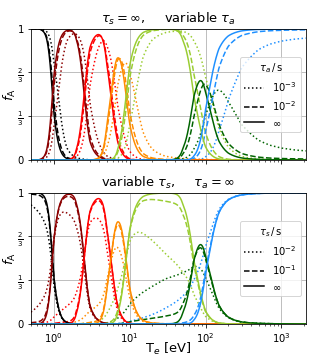

In [48]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4.3,5))

N = 500
lw = [1.5,1.5]
te = np.logspace(np.log10(5e-1),np.log10(2.1e3),N)
labels = [f"Z={i}" for i in range(10)]
# extralabels = [r"$n_e=10^{20}\,/\,\mathrm{m}^3,~ n_0=0,~ \tau_s=\infty,~$ variable $\tau_a$",
#                r"$n_e=10^{20}\,/\,\mathrm{m}^3,~ n_0=0,~ \tau_a=\infty,~$ variable $\tau_s$"]
extralabels = [r"$\tau_s=\infty,\quad$ variable $\tau_a$",
               r"variable $\tau_s,\quad$ $\tau_a=\infty$"]

# plot 1
ne = np.ones(N)*1E20
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, taus=0, taua=0.001)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[0], lw=lw[0], ls=":",
                labels=[r"$10^{-3}$",None,None,None,None,None,None])
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, taus=0, taua=0.01)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[0], lw=lw[0], ls="--",
                labels=[r"$10^{-2}$",None,None,None,None,None,None])
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, taus=0, taua=0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[0], lw=lw[0],
                labels=[r"$\infty$",None,None,None,None,None,None])
axs[0].legend(title=r"$\tau_a\,/\,\mathrm{s}}$", title_fontproperties={"weight":"medium"},loc=7)


# plot 2
ne = np.ones(N)*1E20
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, taus=0.01, taua=0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[1], lw=lw[1], ls=":",
                labels=[r"$10^{-2}$",None,None,None,None,None,None])
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, taus=0.1, taua=0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[1], lw=lw[1], ls="--",
                labels=[r"$10^{-1}$",None,None,None,None,None,None])
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, taus=0, taua=0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[1], lw=lw[1],
                labels=[r"$\infty$",None,None,None,None,None,None])
axs[1].legend(title=r"$\tau_s\,/\,\mathrm{s}}$", title_fontproperties={"weight":"medium"},loc=7)




axs[0].set_xlabel(None)
axs[1].set_xlabel("$\mathrm{T}_e~[\mathrm{eV}]$", va="center", fontsize=13)
for i, (ax, exl) in enumerate(zip(axs, extralabels)):
    ax.set_ylabel("$f_{\\mathrm{A}}$", va="baseline", fontsize=13)
    if i==0:
        ax.set_title(exl, va="baseline", fontsize=13)
    else:
        ax.set_title(exl, va="baseline", fontsize=13)
        
    ax.set_ylim(0,1)
    ax.set_xlim(.5,2100)
    ax.grid(True)
    ax.set_yticks([0,0.333,0.667,1])
    ax.set_yticklabels([0,"$\\frac{1}{3}$","$\\frac{2}{3}$",1])

fig.tight_layout()
fig.subplots_adjust(hspace=0.25, left=0.1, right=0.99, bottom = 0.1)

In [50]:
fig.savefig("/u/phg/adas/images/faplot-taus.pdf")
fig.savefig("/u/phg/adas/images/faplot-taus.png", dpi=200)

In [45]:
te[ np.argmax(10e17 > 1e21 * te**(-3)) ]

10.138033367776883

In [51]:
np.minimum(1e17, 1e21 * te**(-3))[-50:-40], te[-50:-40]

(array([1.26099147e+12, 1.19930346e+12, 1.14063324e+12, 1.08483318e+12,
        1.03176288e+12, 9.81288791e+11, 9.33283905e+11, 8.87627429e+11,
        8.44204480e+11, 8.02905791e+11]),
 array([ 925.61265625,  941.21817506,  957.08679769,  973.22295997,
         989.63117254, 1006.31602206, 1023.28217255, 1040.53436664,
        1058.07742693, 1075.91625734]))

<IPython.core.display.Javascript object>


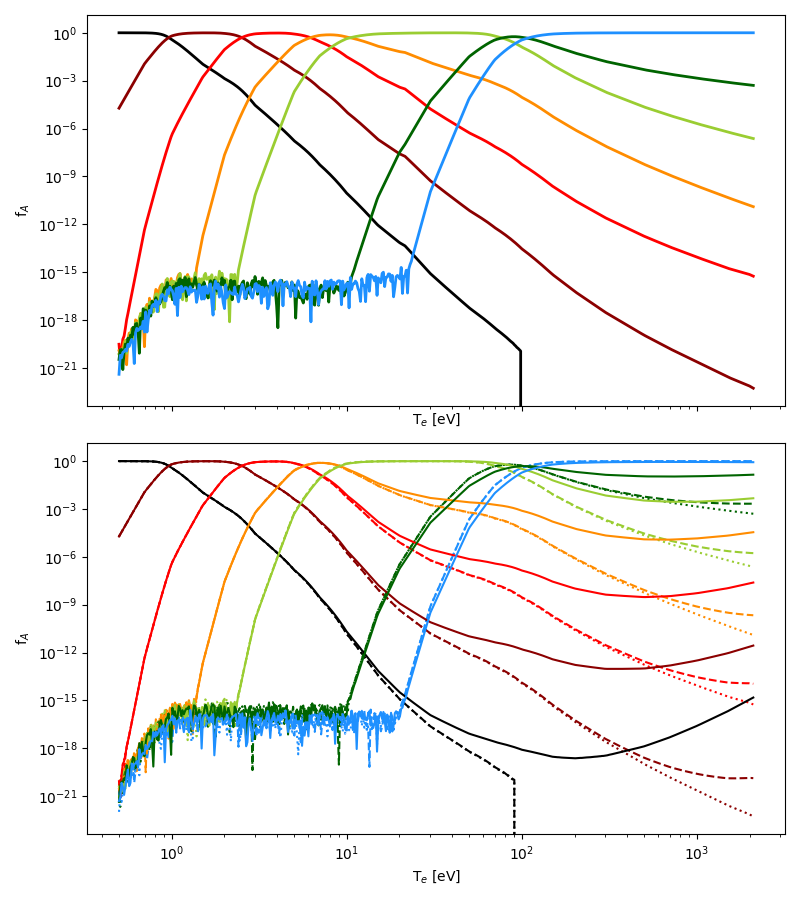

In [35]:
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(8,9))

N = 500
lw = [2,1.5,1.5]
te = np.logspace(np.log10(5e-1),np.log10(2.1e3),N)
labels = [f"Z={i}" for i in range(10)]


# plot 1
ne = np.ones(N)*1e20
n0 = np.minimum(1e17, 1e21 * te**(-3))
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, n0=n0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[0], lw=lw[0], ) # labels=labels)


# plot 3
ne = np.ones(N)*1E20
n0 = np.logspace(10,10,N)
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, n0=n0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[1], lw=lw[1], ls=":",
               ) # labels=[r"$1\cdot 10^{10}$",None,None,None,None,None,None])
n0 = np.logspace(14,14,N)
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, n0=n0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[1], lw=lw[1], ls="--",
               ) # labels=[r"$1\cdot 10^{17}$",None,None,None,None,None,None])
n0 = 1e21 * te**(-3)
n0 = np.logspace(16,16,N)
_,fz,_,_ = phg_calc_fz(elem='c', te=te, ne=ne, n0=n0)
_ = phg_plot_fz(te, fz, fig=fig, ax=axs[1], lw=lw[1],
               ) # labels=[r"$10^{21}\,T_e^{-3}$",None,None,None,None,None,None])
#axs[2].legend(title=r"$\frac{n_0}{\mathrm{m}^{3}} \left( \frac{T_e}{\mathrm{eV}} \right)$",
#              title_fontproperties={"weight":"medium", "size":15}, loc=7)
#axs[2].legend(title=r"$n_e(T_e/\mathrm{eV})/\mathrm{m}^{3}}$",
#              title_fontproperties={"weight":"medium",}, loc=7)


for ax in axs:
    ax.set_yscale("log")
    ax.set_xscale("log")

fig.tight_layout()

# plt vs prb

In [81]:
import utils.colors as colors; reload(colors); clrs = colors.clrs()

def clrs2():
    clrs = colors.clrs()
    i = 0
    while True:
        if i == 4 or i == 6:
            clrs.next()
        if i == 5:
            col = clrs.resetnull()
            [clrs.next() for i in range(4)]
        
        yield clrs.next()
        i += 1

In [95]:
import atomdat.adas.ibal_phg as ibal
import scipy.interpolate as spi
import scipy.linalg as scl

def phg_get_coeffs(elem, ne, te, idx):
    pn = '/u/phg/adas/adf11/'
    year = ["96"]*5

    fns = 'scd'+year[0]+'/scd'+year[0]+'_'+elem+'.dat'; scd = adf11.ADF11(fns,pn=pn)
    fna = 'acd'+year[1]+'/acd'+year[1]+'_'+elem+'.dat'; acd = adf11.ADF11(fna,pn=pn)
    fnc = 'ccd'+year[2]+'/ccd'+year[2]+'_'+elem+'.dat'; ccd = adf11.ADF11(fnc,pn=pn)
    fnt = 'plt'+year[3]+'/plt'+year[3]+'_'+elem+'.dat'; plt = adf11.ADF11(fnt,pn=pn)
    fnb = 'prb'+year[4]+'/prb'+year[4]+'_'+elem+'.dat'; prb = adf11.ADF11(fnb,pn=pn)
    
    scdvals = scd.interpolate(ne=ne, te=te, idx=idx)
    acdvals = acd.interpolate(ne=ne, te=te, idx=idx)
    ccdvals = ccd.interpolate(ne=ne, te=te, idx=idx)
    pltvals = plt.interpolate(ne=ne, te=te, idx=idx)
    prbvals = prb.interpolate(ne=ne, te=te, idx=idx)
    
    return {"scd": scdvals,"acd": acdvals,"ccd": ccdvals,"plt": pltvals,"prb": prbvals}

<IPython.core.display.Javascript object>


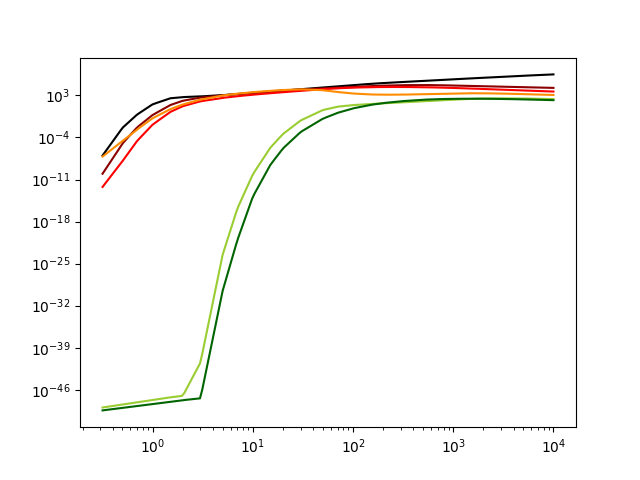

In [108]:
fig, ax = plt.subplots()
cols = clrs2()

te = np.logspace(-0.5, 4, 200)
ne = np.ones_like(te) * 1e20

for idx in range(6):
    coeffs = phg_get_coeffs("c", ne=ne, te=te, idx=idx)
    currcol = next(cols)
    #ax.plot(te, coeffs["prb"], ls="--", c=currcol)
    #ax.plot(te, coeffs["plt"], ls=":", c=currcol)
    ax.plot(te, coeffs["plt"]/coeffs["prb"], c=currcol)
    
ax.set_yscale("log")
ax.set_xscale("log")